In [297]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import csv
from IPython import display

In [298]:
#ESSENTIAL VARIABLES
# create a set of the coordinates in tuple form of the set of points
#COORDINATES = [(1,0), (2,0), (3,1), (3,2), (2,3), (1,3), (0,2), (0,1)] # octagon
#COORDINATES = [(0,1), (1,0), (2,0), (3,1), (1.5,2)] # pentagon
#COORDINATES = [(1,10), (3, 8),(0,2), (1,1), (2,0), (3,0), (4,1), (5,2), (4,3), (3,4), (2,4), (1,3), (2,5), (6,7), (8,12), (4,4), (9,9), (4,6), (12,5), (1,6), (2, 7), (8,2), (9,4), (7,6)] # random
#COORDINATES = [(0,2), (1,1), (2,0), (3,0), (4,1), (5,2), (4,3), (3,4), (2,4), (1,3)] # decigon

with open('coordinates.csv', newline='') as f:
    reader = csv.reader(f)
    COORDINATES = list(reader)

for point in COORDINATES:
    point[0] = int(point[0])
    point[1] = int(point[1])


# number of children a parent births per run
# usually use 500
BIRTH_SIZE = 500

# number of children required to have the fittest distance before the final distance is determined
# higher = more accurate, but takes much more time, especially past 200
# usually use 100
NUM_FITTEST_CHILDREN = 10

"""
max. number of mutations per child.
seems as though the higher the number of coordinates gets, the mutation number has a greater effect.
however, too high, and computation time takes too long.
too low, it's less accurate.
3 seems to be the sweet spot
at lower numbers, the mutations per child don't seem to matter
# usually use 1 for small, 3 for large
"""
MUTATIONS_PER_CHILD = 3

# weighted preference for the algorithm to choose genes from the first "more fit" parent
# set to 0.5 to give equal weight, increase to increase weight to first parent, decrease to decrease weight
PARENT_PROB_WEIGHT = 0.6

# generations per iteration
# set to 0.1 to uncap the generation limit; loop will run forever until fittest isfound
GENERATIONS = 0.1

# number of times to repeat the algorithm
ITERATIONS = 100

In [299]:
%%capture

# crosses genes from both parents, weighting the probability of either one being chosen for any given gene
# probability controlled by PARENT_PROB_WEIGHT
def cross(parent_1, parent_2):
    # create child list to eventually return
    child = []
    
    # set the parents as mates, putting the (maybe) fittest parent first, and the other one last
    parents = [parent_1, parent_2]
    
    # iterate through the parents, passing genes to the child, giving weight to the first parent
    # skip the starting point
    for i in range(1, len(parent_1)):
        # chooses a parent (index) based on the weight given
        prob = random.choices([0, 1], weights=(PARENT_PROB_WEIGHT, 1 - PARENT_PROB_WEIGHT))[0]
        
        # determines the parent that was not chosen, in case the first's genes are already in the child
        opposite_prob = abs(prob - 1)
        
        # add selected parent's gene to child if it is not present in child already
        if parents[prob][i] not in child:
            child.insert(i, parents[prob][i])
        
        # add alternate parent's gene to child if it is not present in child and if the selected parent's is present
        elif parents[opposite_prob][i] not in child:
            child.insert(i, parents[opposite_prob][i])
        
        # if both parents fail to provide a gene the child does not have, find a gene from the selected parent
        # then insert the gene into the child, regardless of what index the parent's gene was found
        else:
            for x in range(1, len(parents[prob]) - 1):
                if parents[prob][x] not in child:
                    child.insert(i, parents[prob][x])
    
    # lastly, insert the starting point into the child
    child.insert(0, parents[0][0])
    
    # return single child
    return child        

# finds distance covered from index 0 to last index, moving left to right
# doesn't return to original index (full circle), stops at last index
def find_dist(coords):
    # get previous value to compute distance
    # here, prev is the first coordinate of the list, but later becomes the i-1 th coordinate
    prev = coords[0]
    
    # distance variable for summation
    dist = 0
    
    # iterate over coordinates, add distances between coordinates to total distance, repeat until done
    for i in range(1, len(coords)):
        # distance formula: sqrt((x change)^2 + (y change)^2)
        temp_dist = np.sqrt(( np.square(( prev[0] - coords[i][0] )) + np.square( prev[1] - coords[i][1] )))
        
        dist += temp_dist
        prev = coords[i]
        
    # return distance covered float
    return dist

# switch two coordinates at random in the list
def mutate(child, mutations):
    # create copy to prevent accidental modifications
    temp_child = child.copy()
    
    # create random indices to swap
    indices_list = []
    for i in range(mutations):
        indices_list.append([random.randint(1, len(temp_child) - 1), random.randint(1, len(temp_child) - 1)])
    
    # swap the two coordinates
    for indices in indices_list:
        temp_gene = temp_child[indices[0]]
        temp_child[indices[0]] = temp_child[indices[1]]
        temp_child[indices[1]] = temp_gene

    # return the list with the swapped coordinates
    return temp_child

# create size number of mutated children, based on the parent
def reproduce(parents, pop_size):
    children = []

    for i in range(pop_size):
        # birth one child, crossing its genes and mutating them
        children.append( mutate( cross(parents[0], parents[1]), MUTATIONS_PER_CHILD ) )
    
    # return every birthed child
    return children
    
# choose best two children from the population
# doesn't choose children at random, it didn't make sense to me to do so
def select(children):
    # these variables select the first two children from the list, and determine their fitness
    # likely to be replaced with more iteration
    lowest = find_dist(children[0])
    second_lowest = find_dist(children[1])
    fittest_child = children[0]
    second_fittest_child = children[1]
    
    # iterate through every other child, checking if their fitness is better than either two selected children
    for i in range(2, len(children) - 1):
        child_distance = find_dist(children[i])
        
        # replace first fittest child if the current child is fitter
        if child_distance < lowest:
            lowest = child_distance
            fittest_child = children[i]
            
        # replace second fittest child if the current child is fitter, but less fit or equal fitness of the first child
        elif child_distance < second_lowest:
            second_lowest = child_distance
            second_fittest_child = children[i]
    
    # return list of the two fittest children
    return [fittest_child, second_fittest_child]

In [300]:
# sloppily made this a function to iterate easier
def sim(iteration, ITERATIONS):
    begin_time = time.time() # record time at beginning of execution

    original_parents = [COORDINATES[1:], COORDINATES[1:]]

    # shuffle the two parents randomly
    random.shuffle(original_parents[0])
    random.shuffle(original_parents[1])

    # insert the starting position into both parents
    original_parents[0].insert(0, COORDINATES[0])
    original_parents[1].insert(0, COORDINATES[0])

    # set the fittest children equal to the original parents initially
    fittest_children = original_parents.copy()

    # set the previous generation's parents equal to the original parents initially
    last_parents = original_parents.copy()
    fittest_child = original_parents.copy()
    
    # sequence list for animation export
    ANIM_FRAME_SEQ = [original_parents[0]]
    
    # set the highest parent distance to a large number initially
    parent_dist = [100000000, 100000000]

    # set the number of equivalent children equal to 0 initially
    equiv_children = 0
# run until the "best" distance is found equiv_children times, to ensure the children really are close to the fittest
    fittest_found = False
    gens = 0
    while not fittest_found and gens < GENERATIONS:
        # if generations variable is 0.1, never increment, let the loop terminate when fittest_found
        if GENERATIONS != 0.1:
            gens += 1
        # create new population based off the parents with a birth size of BIRTH_SIZE
        members = reproduce(last_parents, BIRTH_SIZE)

        # choose the fittest two children, which become the parents of the next generation
        fittest_children = select(members)
        # find the distance traveled of the fittest child
        child_dist = [find_dist(fittest_children[0]), find_dist(fittest_children[1])]
        #display.display(find_dist(last_parents[0]))
        # if the child is fitter than the parent, replace the parent with the child
        for i in range(len(child_dist) - 1):

            # if the first child is fitter than the first parent, replace the first parent
            if child_dist[i] < parent_dist[0]:
                equiv_children = 0 # reset number of equivalent children
                parent_dist[0] = child_dist[i] # save the fitness score
                last_parents[0] = fittest_children[i] # save the child

                # add the frame to the list of frames
                ANIM_FRAME_SEQ.append(fittest_children[i])

            # if the child is less fit than the first parent, but fitter than the second, replace the second parent
            elif child_dist[i] < parent_dist[1]:
                equiv_children = 0 # reset number of equivalent children
                parent_dist[1] = child_dist[i] # save the fitness score
                last_parents[1] = fittest_children[i] # save the child

            # if the child is equivalent to both parents, determine the best child
            # using or here might be better, unsure
            elif child_dist[i] == parent_dist[0] and child_dist[i] == parent_dist[0]:   
                end_time = time.time() # record current time of execution
                time_diff = end_time - begin_time # calculate elapsed execution time
                # increase the count of equivalent children
                equiv_children += 1

                # output the progress
                display.clear_output(wait=True)
                display.display(f'Current Best Fitness: {child_dist[i]} // {equiv_children}/{NUM_FITTEST_CHILDREN}' +
                f' equivalents found // {round(time_diff)} seconds elapsed // {iteration}/{ITERATIONS} iterations' +
                f' complete')

                # determine fittest child if the number of equivalent children reaches the provided number
                if equiv_children >= NUM_FITTEST_CHILDREN:
                    fittest_found = True
            
    end_time = time.time() # record  final time of end of execution
    time_diff = end_time - begin_time # calculate final execution time
    return last_parents, ANIM_FRAME_SEQ, time_diff



In [301]:
# future should add parameters to change the 6 big variables while iterating
# might be useful in pursuing the "good" eggs and discarding the bad ones
best = 1000000
for i in range(0, ITERATIONS):
    last_parents_TEMP, ANIM_FRAME_SEQ_TEMP, time_diff_TEMP = sim(i, ITERATIONS)
    if find_dist(last_parents_TEMP[0]) < best:
        last_parents = last_parents_TEMP
        ANIM_FRAME_SEQ = ANIM_FRAME_SEQ_TEMP
        time_diff = time_diff_TEMP
        best = find_dist(last_parents[0])

'Current Best Fitness: 168.9052746343056 // 10/10 equivalents found // 9 seconds elapsed // 99/100 iterations complete'

151.00638509118642


Start Point:[25, 0]

GA's Best Sequence[[25, 0], [19, 1], [13, 3], [8, 7], [4, 12], [1, 17], [0, 23], [0, 30], [2, 36], [6, 41], [10, 45], [16, 48], [22, 50], [28, 50], [34, 48], [40, 45], [44, 41], [48, 36], [50, 30], [50, 23], [49, 17], [46, 12], [42, 7], [37, 3], [31, 1]]
GA's Best Distance: 151.00638509118642

Original Sequence:[[25, 0], [48, 36], [13, 3], [0, 23], [19, 1], [37, 3], [4, 12], [46, 12], [28, 50], [34, 48], [16, 48], [50, 23], [50, 30], [49, 17], [31, 1], [2, 36], [44, 41], [22, 50], [0, 30], [10, 45], [8, 7], [40, 45], [42, 7], [1, 17], [6, 41]]
Original Distance: 742.5391712799853

Percent Improvement:79.66351258871875%

Execution Time: 10.933412075042725 seconds


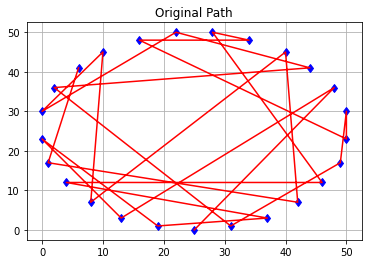

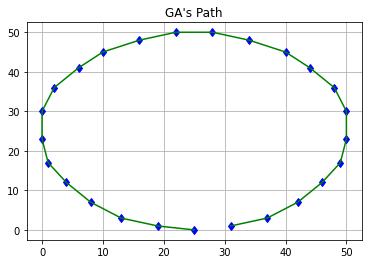

In [302]:
# OUTPUT FINAL DATA
# information about old sequence of coordinates, then GA's sequence
print("Start Point:" + str(original_parents[0][0]) + "\n")
print("GA's Best Sequence" + str(last_parents[0]))
print("GA's Best Distance: " + str(find_dist(last_parents[0])) + "\n")

print("Original Sequence:" + str(original_parents[0]))
print("Original Distance: " + str(find_dist(original_parents[0])) + "\n")

pct_change = ( find_dist(original_parents[0]) - find_dist(last_parents[0]) )/ find_dist(original_parents[0]) * 100
print("Percent Improvement:" + str(pct_change) + "%\n")

print("Execution Time: " + str(time_diff) + " seconds")
# charts of old sequence vs GA's sequence
x, y = np.array(original_parents[0]).T
x_path, y_path = np.array(last_parents[0]).T

plt.title("Original Path")
plt.plot(x, y, "bd")
plt.plot(x, y, "r")
plt.grid()
plt.show()

plt.title("GA's Path")
plt.plot(x_path, y_path, "bd")
plt.plot(x_path, y_path, "g")
plt.grid()
plt.show()

[[[25, 0], [8, 7], [46, 12], [16, 48], [44, 41], [13, 3], [0, 23], [42, 7], [49, 17], [0, 30], [10, 45], [48, 36], [37, 3], [22, 50], [50, 30], [19, 1], [31, 1], [2, 36], [40, 45], [50, 23], [6, 41], [34, 48], [4, 12], [28, 50], [1, 17]], [[25, 0], [42, 7], [46, 12], [40, 45], [44, 41], [13, 3], [0, 23], [8, 7], [1, 17], [0, 30], [10, 45], [6, 41], [4, 12], [22, 50], [16, 48], [28, 50], [34, 48], [50, 30], [50, 23], [2, 36], [31, 1], [19, 1], [37, 3], [48, 36], [49, 17]], [[25, 0], [13, 3], [46, 12], [40, 45], [44, 41], [2, 36], [4, 12], [8, 7], [1, 17], [0, 30], [10, 45], [6, 41], [0, 23], [22, 50], [16, 48], [28, 50], [34, 48], [50, 30], [50, 23], [42, 7], [31, 1], [19, 1], [37, 3], [48, 36], [49, 17]], [[25, 0], [13, 3], [46, 12], [40, 45], [44, 41], [0, 23], [4, 12], [8, 7], [1, 17], [0, 30], [10, 45], [6, 41], [22, 50], [2, 36], [16, 48], [28, 50], [34, 48], [50, 30], [48, 36], [42, 7], [31, 1], [19, 1], [37, 3], [50, 23], [49, 17]], [[25, 0], [37, 3], [46, 12], [40, 45], [44, 41]

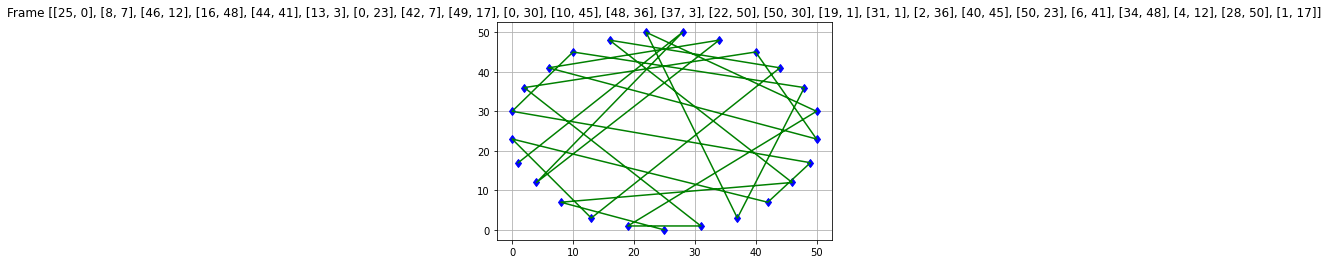

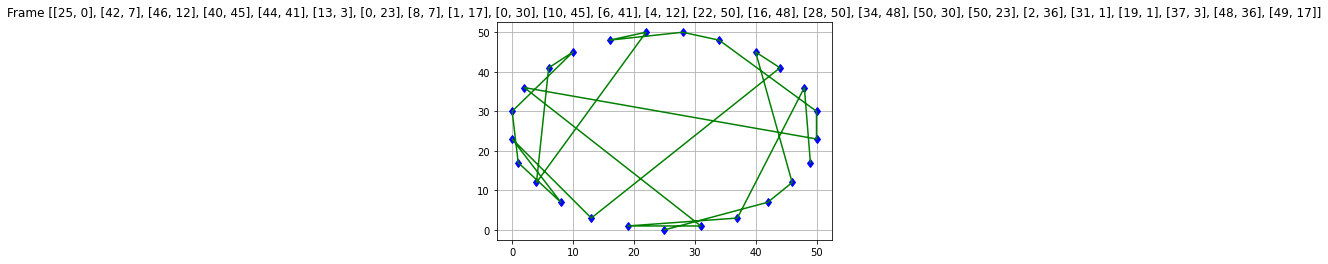

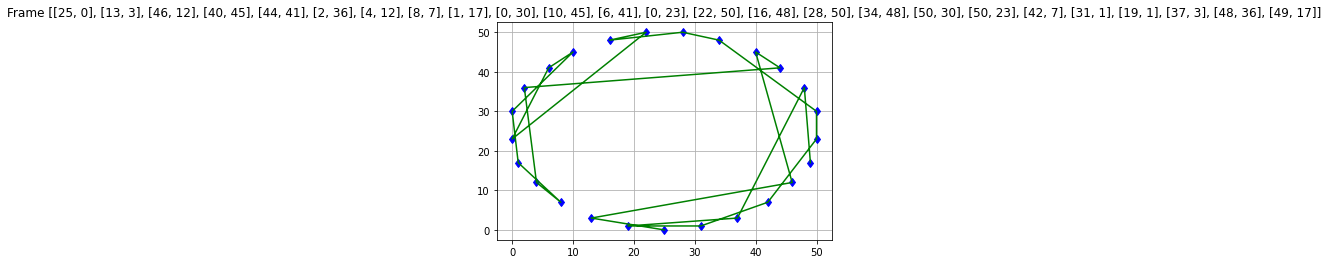

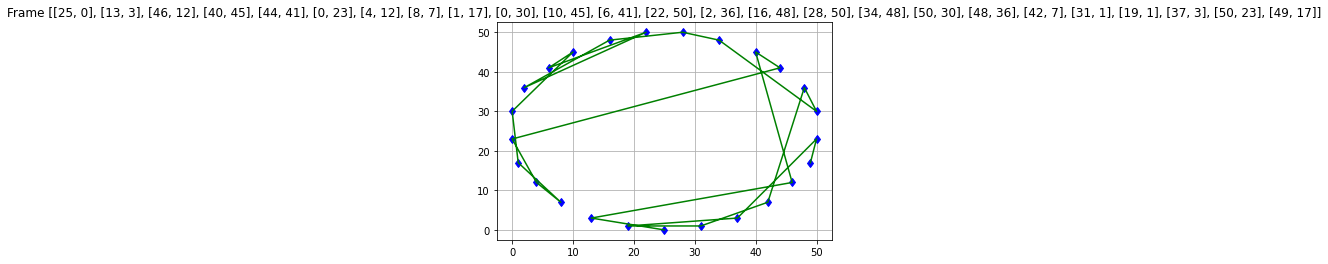

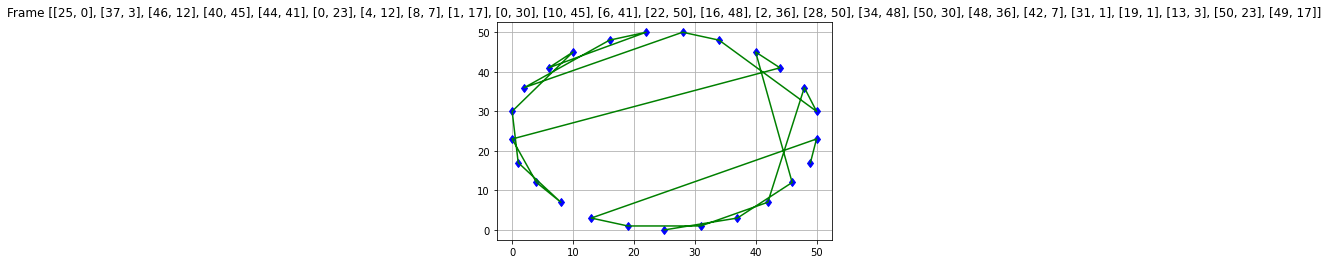

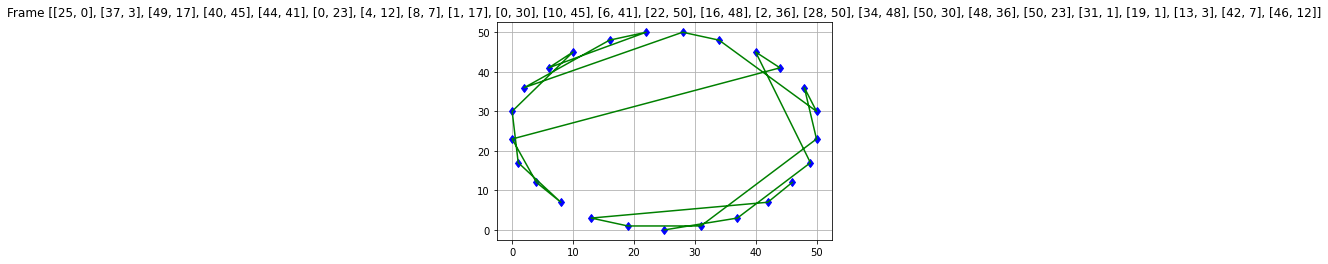

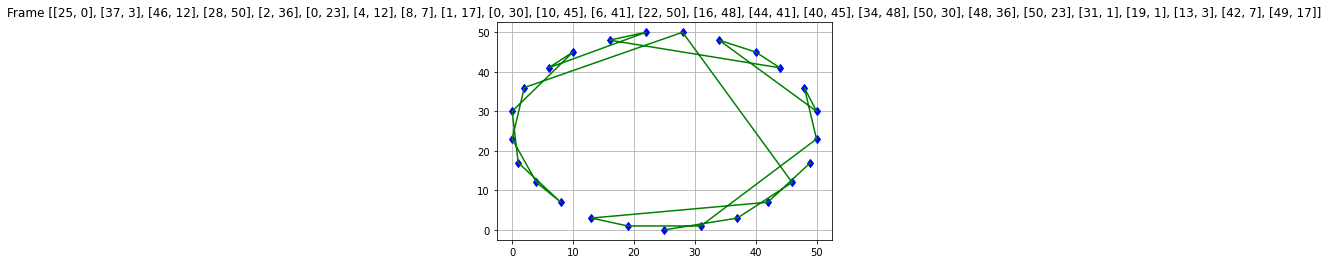

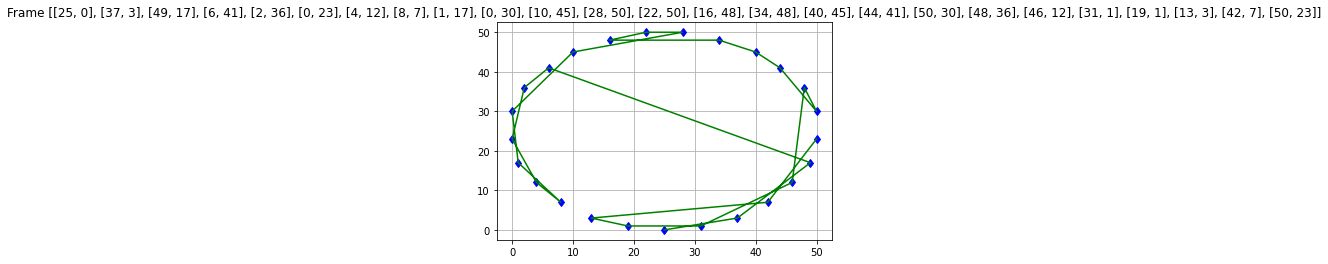

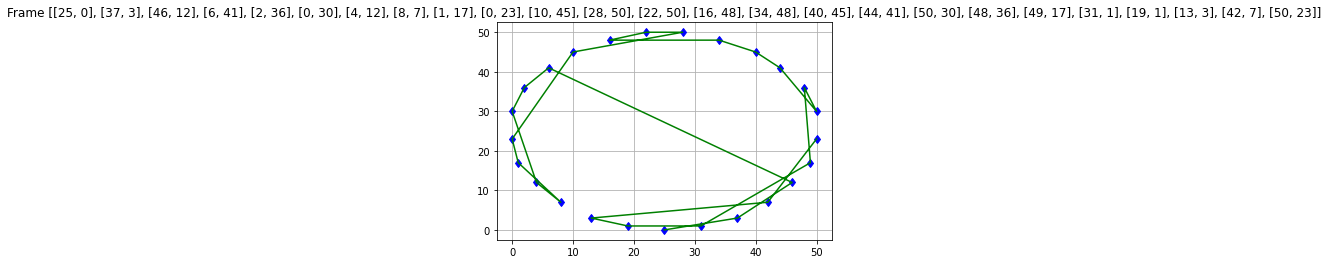

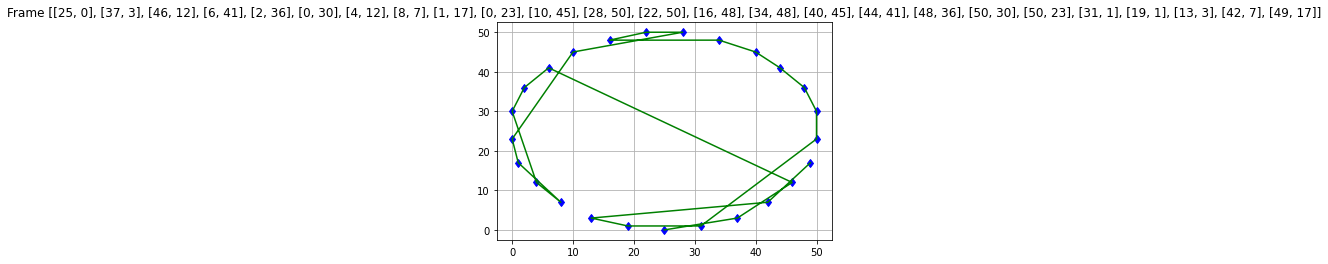

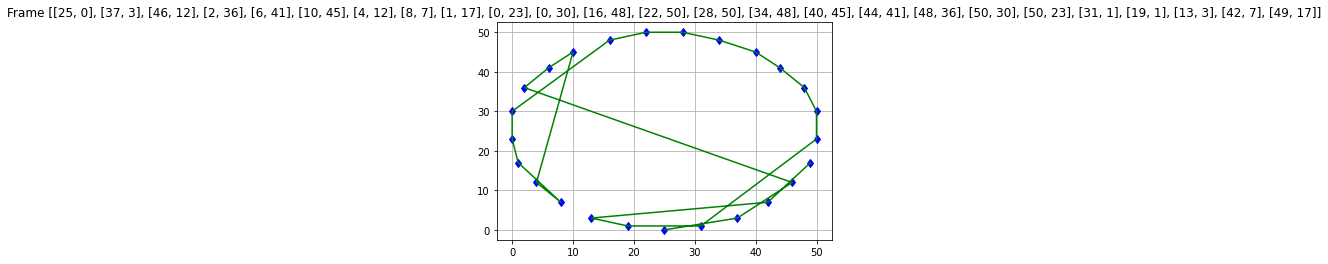

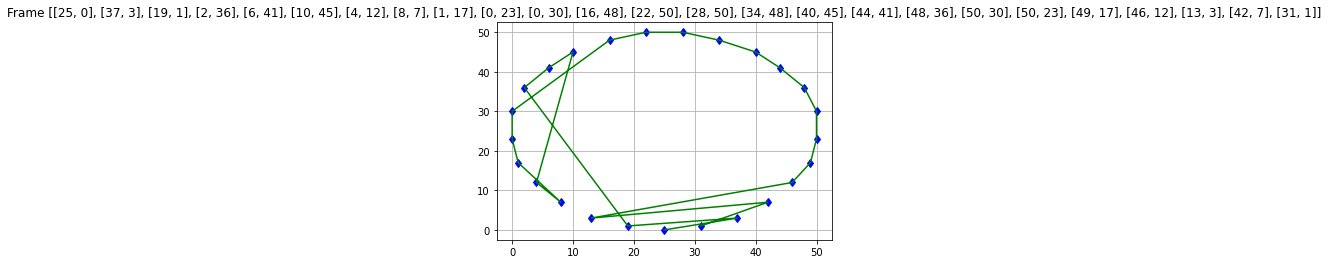

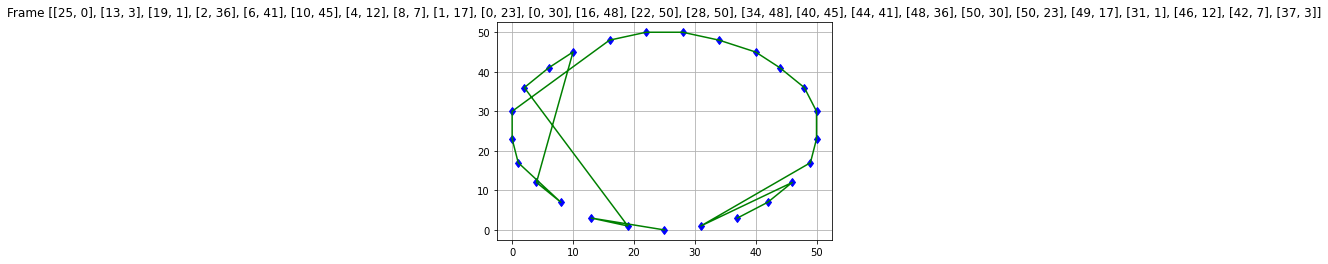

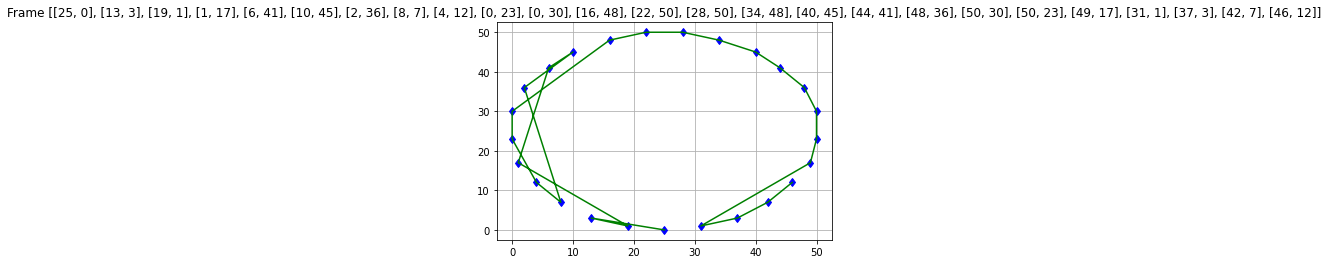

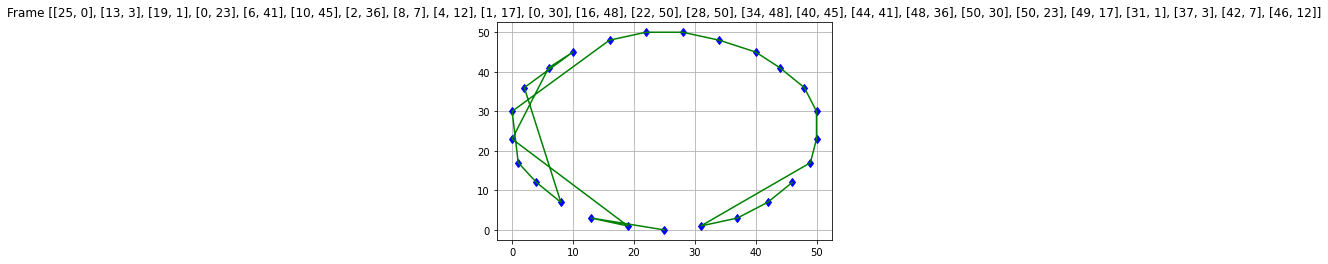

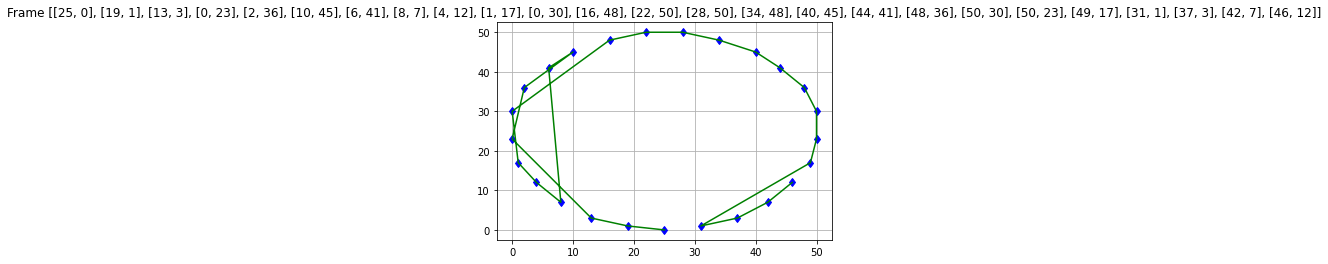

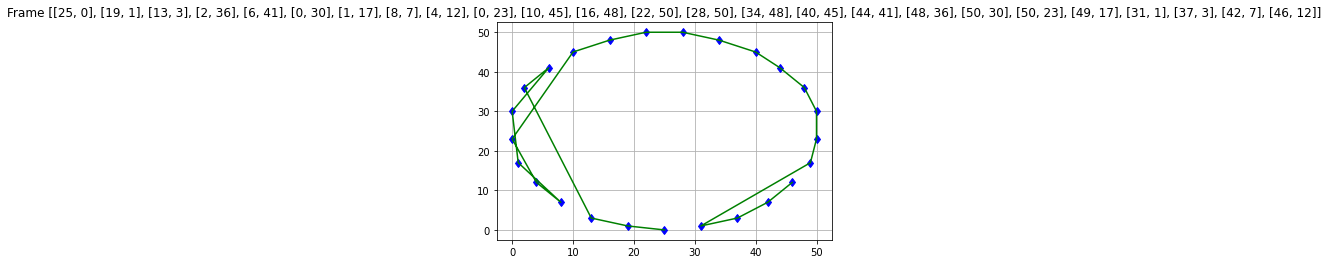

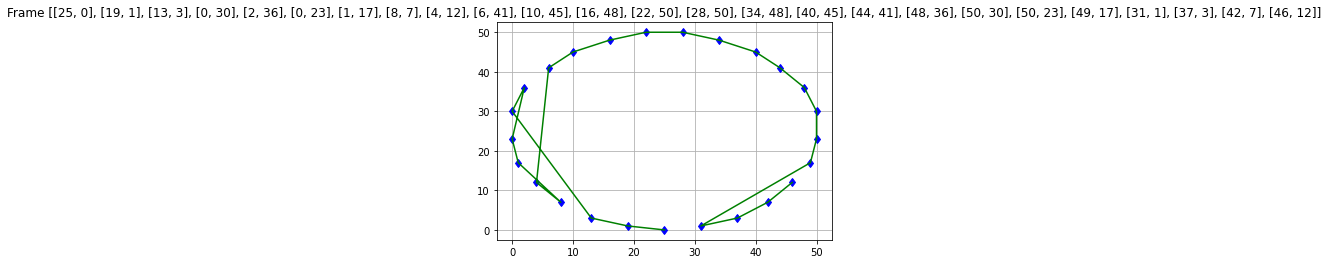

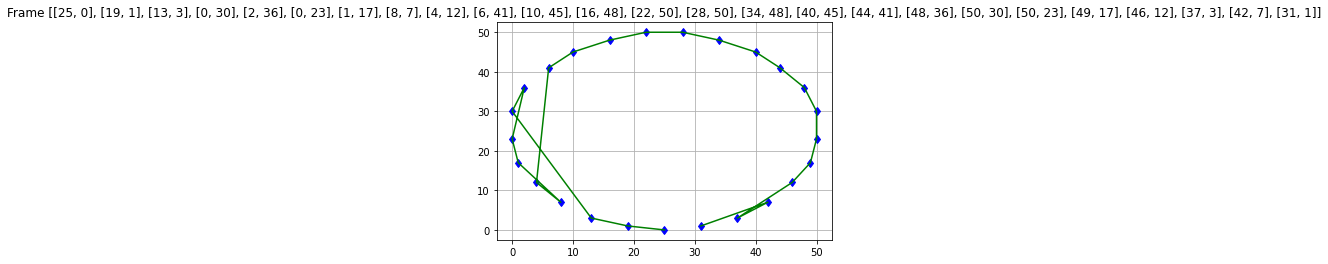

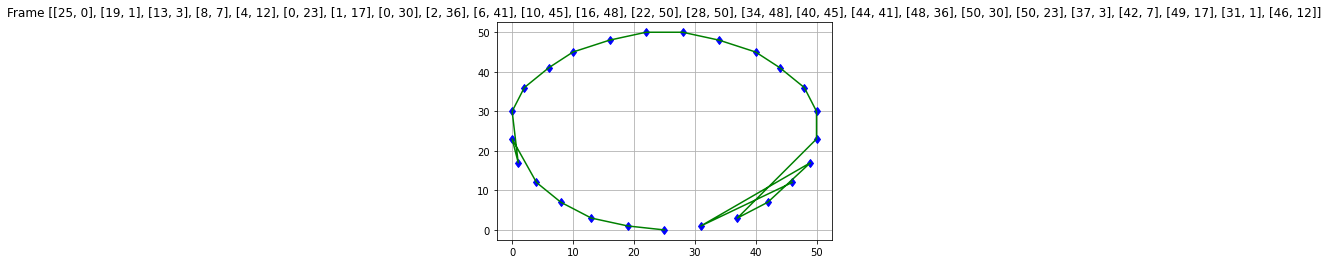

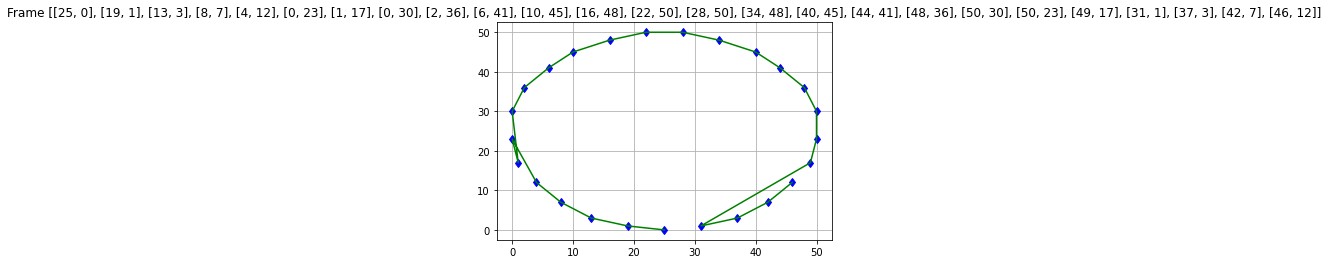

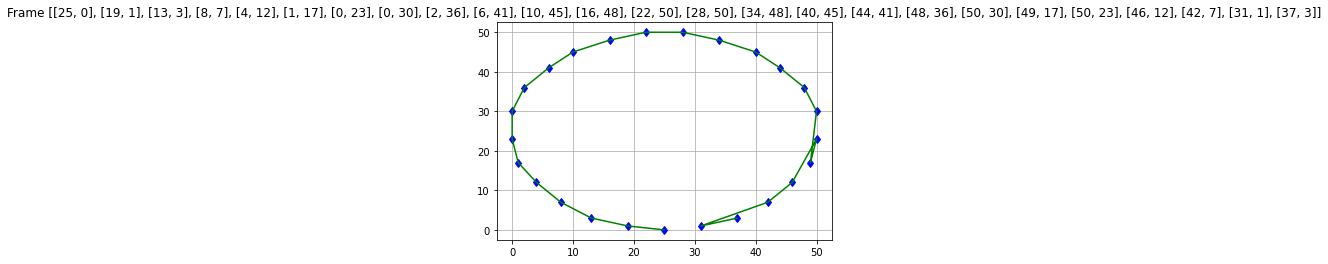

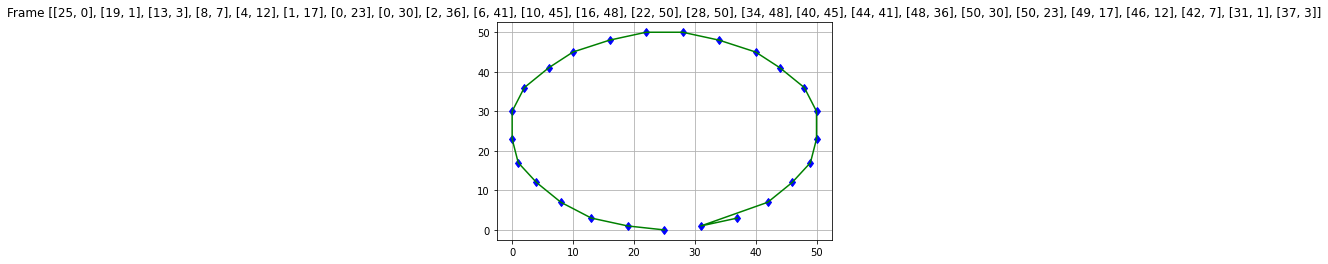

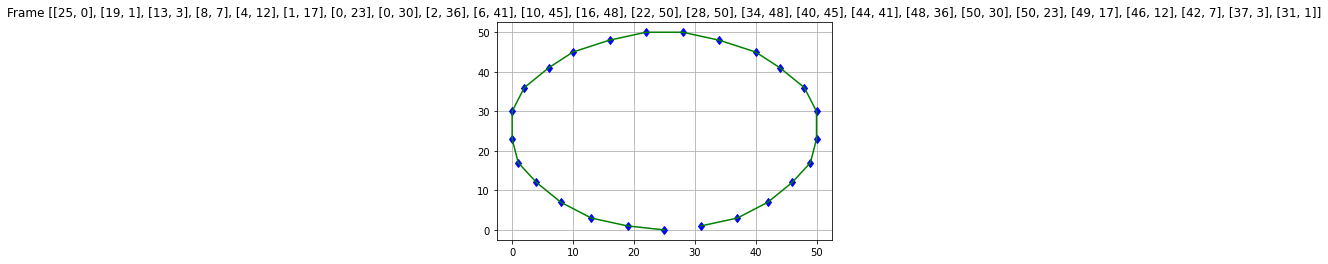

In [303]:
print(ANIM_FRAME_SEQ)
for i in range(len(ANIM_FRAME_SEQ) ):
    plt.title(f'Frame {ANIM_FRAME_SEQ[i]}')
    x_frame, y_frame = np.array(ANIM_FRAME_SEQ[i]).T
    plt.plot(x_frame, y_frame, "bd")
    plt.plot(x_frame, y_frame, "g")
    plt.savefig(f'Frame{len(ANIM_FRAME_SEQ) - (i+1)}')
    plt.grid()
    plt.show()